In [ ]:
# !unzip "/content/icml_face_data.csv.zip"

In [ ]:
pip install scikit-plot

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import math
import numpy as np
import pandas as pd

import scikitplot
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.utils import np_utils
from keras.callbacks import CSVLogger

Data

In [ ]:
# df = pd.read_csv('fer2013.csv')
df = pd.read_csv('../input/facial-expression-recognitionferchallenge/fer2013/fer2013/fer2013.csv')
df.rename({' pixels': 'pixels'}, axis=1, inplace=True)

print(df.shape) # (35887, 3)

df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
#df['pixels'][0].shape

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


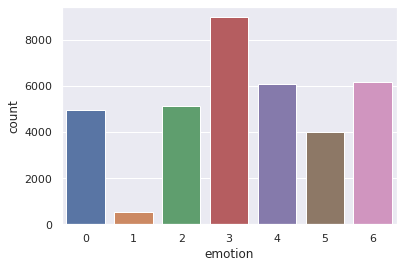

In [ ]:
df.emotion.value_counts()

# OUTPUT
'''
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64
'''

sns.countplot(df.emotion)
pyplot.show()

In [ ]:
emotion_label_to_text = {
  0: 'anger',
  1: 'disgust',
  2: 'fear',
  3: 'happiness',
  4: 'sadness',
  5: 'surprise',
  6: 'neutral'
}

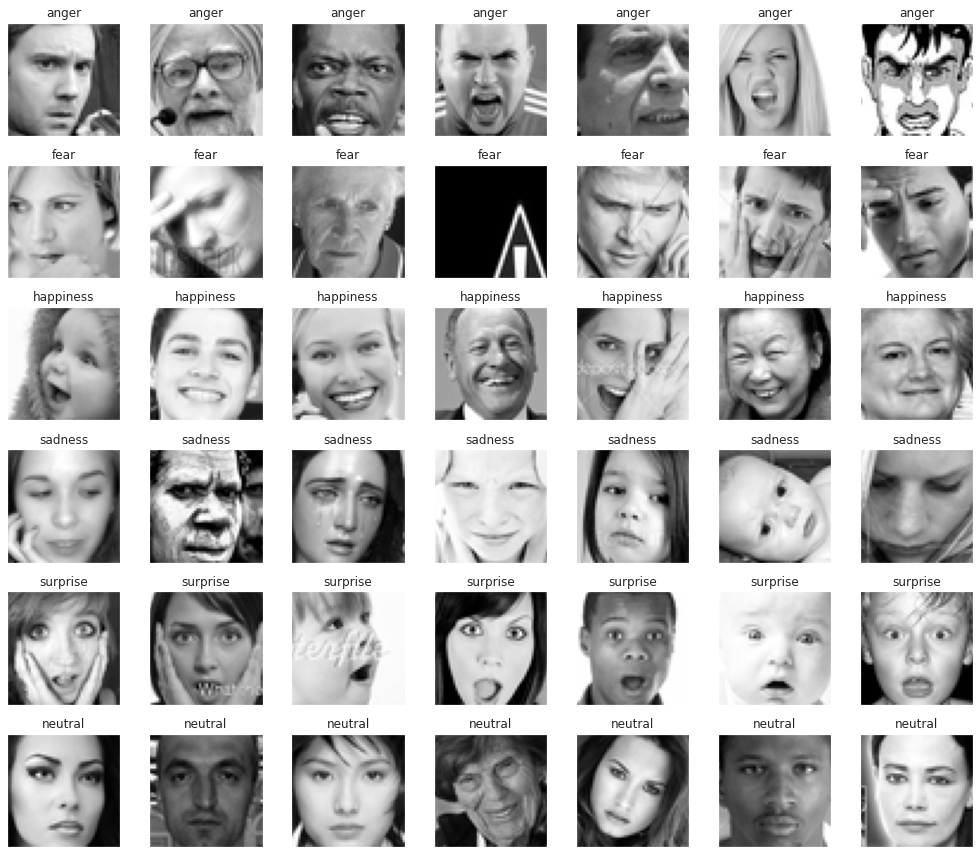

In [ ]:
# Showing Images

fig = pyplot.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        pyplot.tight_layout()

In [ ]:
# For only 3 classes
#INTERESTED_LABELS = [3, 4, 6]

# For only 6 classes
INTERESTED_LABELS = [0, 2, 3, 4, 5,6]

# For all 7 classes
#INTERESTED_LABELS = [0, 2, 3, 4, 5, 6]

df = df[df.emotion.isin(INTERESTED_LABELS)]
df.shape # (21264, 3)

(35340, 3)

In [ ]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)
print(img_array.shape) # (21264, 48, 48, 1)

le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = np_utils.to_categorical(img_labels)
print(img_labels.shape) # (21264, 3)

le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
le_name_mapping # {3: 0, 4: 1, 6: 2}

(35340, 48, 48, 1)
(35340, 6)


{0: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5}

In [ ]:
# A = img_array[0]

# from google.colab.patches import cv2_imshow
# cv2_imshow(A)

# import cv2
# cv2.imwrite("filename.jpg", A)

# A.shape

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(
  img_array,
  img_labels,
  shuffle=True,
  stratify=img_labels,
  test_size=0.1,
  random_state=42
)

del df
del img_array
del img_labels

print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

# OUTPUT
'''
((19137, 48, 48, 1), (2127, 48, 48, 1), (19137, 3), (2127, 3))
'''

(31806, 48, 48, 1) (3534, 48, 48, 1) (31806, 6) (3534, 6)


'\n((19137, 48, 48, 1), (2127, 48, 48, 1), (19137, 3), (2127, 3))\n'

In [ ]:
# Normalizing arrays, as neural networks are very sensitive to unnormalized data.
X_train = X_train / 255.
X_valid = X_valid / 255.

img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)

train_datagen.fit(X_train)

Architecture

In [ ]:
def build_net(optim):
    net = Sequential(name='DCNN')

    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            input_shape=(img_width, img_height, img_depth),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1'))
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2'))

    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    net.add(Dropout(0.4, name='dropout_1'))

    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3'))
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
    net.add(BatchNormalization(name='batchnorm_4'))

    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    net.add(Dropout(0.4, name='dropout_2'))

    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
    net.add(BatchNormalization(name='batchnorm_5'))
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
    net.add(BatchNormalization(name='batchnorm_6'))

    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    net.add(Dropout(0.5, name='dropout_3'))

    net.add(Flatten(name='flatten'))

    net.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_7'))

    net.add(Dropout(0.6, name='dropout_4'))

    net.add(
        Dense(
            num_classes,
            activation='softmax',
            name='out_layer'
        )
    )

    net.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
    )

    net.summary()

    return net

Training

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

csv_logger = CSVLogger(
    'training.log',
    separator=',',
    append=False
)

callbacks = [
    early_stopping,
    lr_scheduler,
    csv_logger,
]

In [ ]:
# Hyperparameters

batch_size = 32 #batch size of 32 performs the best.

epochs = 100

optims = [
  optimizers.Nadam(
      learning_rate=0.0002500000118743628,
      #learning_rate=0.001,
     # rho=0.9,
      #momentum=0.0,
      #epsilon=1e-07,
      #centered=False,
      #learning_rate=0.0002500000118743628,accuracy of 70.87 and loss of 79.44
      #with rms prop accuracy of 70.3 and loss of 0.8
      beta_1=0.9,
      beta_2=0.999,
      epsilon=1e-07,
      name='RMSprop'),

  optimizers.Adam(0.0002500000118743628),
]

In [ ]:
model = build_net(optims[1])

history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_valid),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=True
)

Model: "DCNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 64)        1664      
_________________________________________________________________
batchnorm_1 (BatchNormalizat (None, 48, 48, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        102464    
_________________________________________________________________
batchnorm_2 (BatchNormalizat (None, 48, 48, 64)        256       
_________________________________________________________________
maxpool2d_1 (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       73856  

Results

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-package

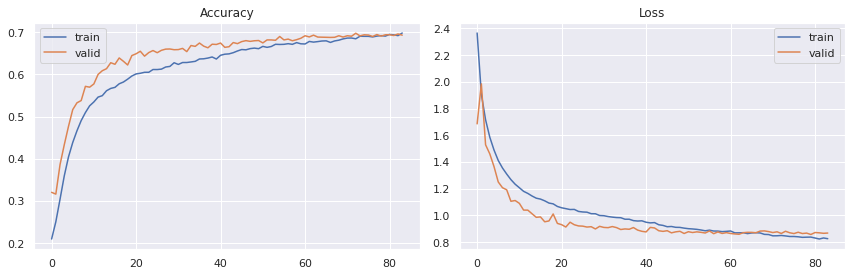

In [ ]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history_dcnn.png')
pyplot.show()

In [ ]:
model_yaml = model.to_json()
with open("model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)

model.save("model.h5")

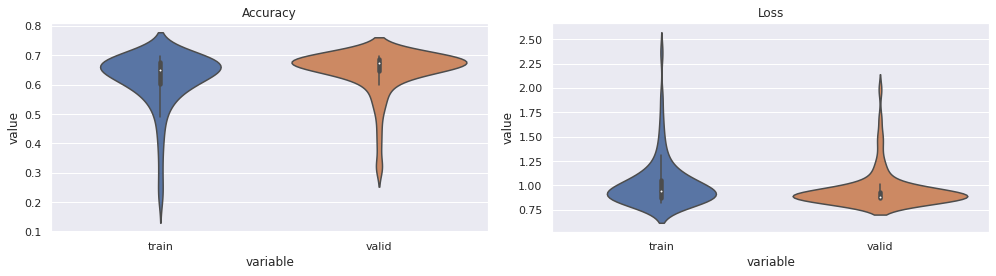

In [ ]:
df_accu = pd.DataFrame({'train': history.history['accuracy'], 'valid': history.history['val_accuracy']})
df_loss = pd.DataFrame({'train': history.history['loss'], 'valid': history.history['val_loss']})

fig = pyplot.figure(0, (14, 4))
ax = pyplot.subplot(1, 2, 1)
sns.violinplot(x="variable", y="value", data=pd.melt(df_accu), showfliers=False)
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.violinplot(x="variable", y="value", data=pd.melt(df_loss), showfliers=False)
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('performance_dist.png')
pyplot.show()

In [ ]:
# predict_x = model.predict(X_valid)
classes_x = np.argmax(model.predict(X_valid), axis=1)

In [ ]:
yhat_valid = (model.predict(X_valid) > 0.5).astype("int32")

In [ ]:
yhat_valid[1]

array([0, 0, 1, 0, 0, 0], dtype=int32)

In [ ]:
y_valid[1]

array([0., 0., 1., 0., 0., 0.], dtype=float32)

In [ ]:
rounded_labels=np.argmax(y_valid, axis=1)
rounded_labels[1]

2

In [ ]:
model.evaluate(X_valid, y_valid)

111/111 [==============================] - 1s 9ms/step - loss: 0.8650 - accuracy: 0.6978


[0.8649854063987732, 0.6977928876876831]

In [ ]:

batch_size = 32 #batch size of 32 performs the best.

epochs = 50

optims = [
  optimizers.Nadam(
      learning_rate=0.0005000000237487257,
      beta_1=0.9,
      beta_2=0.999,
      epsilon=1e-07,
      name='Nadam'),

  optimizers.Adam(0.001),
]
model = build_net(optims[1])

history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_valid),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=True
)

Model: "DCNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 64)        1664      
_________________________________________________________________
batchnorm_1 (BatchNormalizat (None, 48, 48, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        102464    
_________________________________________________________________
batchnorm_2 (BatchNormalizat (None, 48, 48, 64)        256       
_________________________________________________________________
maxpool2d_1 (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       73856  

In [ ]:
model.evaluate(X_valid, y_valid)

111/111 [==============================] - 1s 8ms/step - loss: 0.8924 - accuracy: 0.6777


[0.8923709392547607, 0.6777023077011108]

1st training results

total wrong validation predictions: 1139


              precision    recall  f1-score   support

           0       0.56      0.66      0.61       495
           1       0.64      0.34      0.44       512
           2       0.86      0.88      0.87       899
           3       0.58      0.54      0.56       608
           4       0.77      0.78      0.77       400
           5       0.59      0.75      0.66       620

    accuracy                           0.68      3534
   macro avg       0.67      0.66      0.65      3534
weighted avg       0.68      0.68      0.67      3534



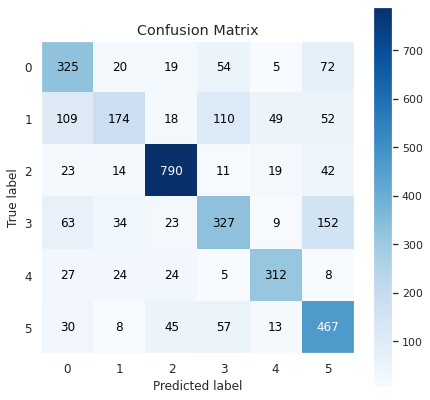

In [ ]:
predict_x=model.predict(X_valid)
yhat_valid=np.argmax(predict_x,axis=1)
#yhat_valid = model.predict(X_valid)
scikitplot.metrics.plot_confusion_matrix(np.argmax(y_valid, axis=1), yhat_valid, figsize=(7,7))
pyplot.savefig("confusion_matrix_dcnn.png")

print(f'total wrong validation predictions: {np.sum(np.argmax(y_valid, axis=1) != yhat_valid)}\n\n')
print(classification_report(np.argmax(y_valid, axis=1), yhat_valid))



2nd training results

total wrong validation predictions: 1139


              precision    recall  f1-score   support

           0       0.56      0.66      0.61       495
           1       0.64      0.34      0.44       512
           2       0.86      0.88      0.87       899
           3       0.58      0.54      0.56       608
           4       0.77      0.78      0.77       400
           5       0.59      0.75      0.66       620

    accuracy                           0.68      3534
   macro avg       0.67      0.66      0.65      3534
weighted avg       0.68      0.68      0.67      3534



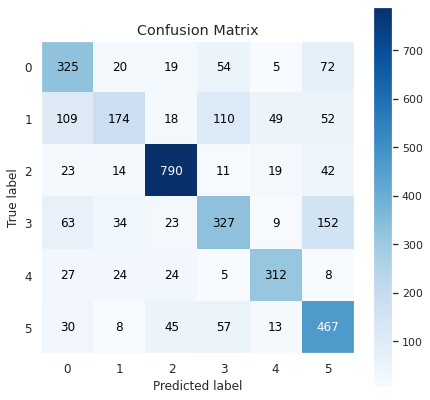

In [ ]:
predict_x=model.predict(X_valid)
yhat_valid=np.argmax(predict_x,axis=1)
#yhat_valid = model.predict(X_valid)
scikitplot.metrics.plot_confusion_matrix(np.argmax(y_valid, axis=1), yhat_valid, figsize=(7,7))
pyplot.savefig("confusion_matrix_dcnn.png")

print(f'total wrong validation predictions: {np.sum(np.argmax(y_valid, axis=1) != yhat_valid)}\n\n')
print(classification_report(np.argmax(y_valid, axis=1), yhat_valid))

